In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from IPython.display import display
from sklearn.metrics import silhouette_score
from scipy.stats.mstats import winsorize

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_theme(style="whitegrid", palette="Set2")  
BASE_PALETTE = sns.color_palette()

plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.2,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "grid.alpha": 0.4,
    "grid.linestyle": "--"
})

In [2]:
df = pd.read_csv('data/dataset_with_user_features.csv')
df.head(3)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Daily meals frequency,Calories,sugar_g,serving_size_g,rating,Name of Exercise,Sets,Reps,Benefit,Burns Calories (per 30 min),Target Muscle Group,Equipment Needed,Difficulty Level,Body Part,Type of Muscle,Workout,sodium_g,cholesterol_g,Carbs,Proteins,Fats,meal_name,BMR,PAL,TDEE
0,35,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,1.50,4,2,24.87,3,1806.0,31.77,120.47,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,342.58,"Shoulders, Triceps",Cable Machine,3,Legs,Lats,Dumbbell flyes,1.72994,0.28505,267.68,106.05,71.63,Grilled Vegan Lunch,1495.20,1.900,2840.88000
1,23,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,1.90,4,2,23.48,3,1577.0,12.34,109.15,1.92,Bear Crawls,4,16,Strengthens lower abs,357.16,"Back, Core, Shoulders",Step or Box,2,Chest,Lats,Lateral raises,0.69308,0.30061,214.32,85.41,56.97,Fried Vegetarian Lunch,1256.85,1.900,2388.01500
2,33,Female,58.98,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,1.88,3,1,21.15,2,1608.0,42.81,399.43,4.70,Dips,5,22,Builds chest strength,359.63,"Quadriceps, Glutes",Step or Box,2,Arms,Grip Strength,Standing calf raises,2.14248,0.21542,246.04,98.11,65.48,Boiled Paleo Breakfast,1307.55,1.725,2255.52375


In [3]:
df['diet_type'] = df['meal_name'].str.split().str[1]
input_features = [
    'Age',
    'Gender',
    'Weight (kg)',
    'Height (m)',
    'BMI',
    'Experience_Level',
    'Workout_Frequency (days/week)',
    'Daily meals frequency',
    'diet_type'
]

df_clustering_data = df[input_features]
df_clustering_data.head(3)

,Age,Gender,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days/week),Daily meals frequency,diet_type
0,35,Male,65.27,1.62,24.87,2,4,3,Vegan
1,23,Female,56.41,1.55,23.48,2,4,3,Vegetarian
2,33,Female,58.98,1.67,21.15,1,3,2,Paleo


Encoding of categorical features Genger and Diet type.

In [4]:
df_clustering_data = pd.get_dummies(df_clustering_data, columns=['Gender', 'diet_type'])
df_clustering_data.head(3)

,Age,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days/week),Daily meals frequency,Gender_Female,Gender_Male,diet_type_Balanced,diet_type_Keto,diet_type_Low-Carb,diet_type_Paleo,diet_type_Vegan,diet_type_Vegetarian
0,35,65.27,1.62,24.87,2,4,3,False,True,False,False,False,False,True,False
1,23,56.41,1.55,23.48,2,4,3,True,False,False,False,False,False,False,True
2,33,58.98,1.67,21.15,1,3,2,True,False,False,False,False,True,False,False


In [5]:
numeric_cols = ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 
                'Workout_Frequency (days/week)', 'Daily meals frequency']
  
mean_dict = {}
std_dict = {}

for col in numeric_cols:
    mean = df_clustering_data[col].mean()
    std = df_clustering_data[col].std()
    mean_dict[col] = mean
    std_dict[col] = std
    df_clustering_data[col + '_scaled'] = (df_clustering_data[col] - mean) / std

scaled_numeric_cols = [col + '_scaled' for col in numeric_cols]
categorical_scaled_cols = [c for c in df_clustering_data.columns if c not in numeric_cols and '_scaled' not in c]
final_features = scaled_numeric_cols + categorical_scaled_cols

X = df_clustering_data[final_features].values
df_clustering_data[final_features].head(3)

,Age_scaled,Weight (kg)_scaled,Height (m)_scaled,BMI_scaled,Workout_Frequency (days/week)_scaled,Daily meals frequency_scaled,Experience_Level,Gender_Female,Gender_Male,diet_type_Balanced,diet_type_Keto,diet_type_Low-Carb,diet_type_Paleo,diet_type_Vegan,diet_type_Vegetarian
0,-0.321350,-0.403548,-0.811881,-0.001794,0.743868,0.211608,2,False,True,False,False,False,False,True,False
1,-1.312164,-0.823087,-1.362754,-0.210191,0.743868,0.211608,2,True,False,False,False,False,False,False,True
2,-0.486485,-0.701392,-0.418400,-0.559517,-0.351407,-1.360622,1,True,False,False,False,False,True,False,False


#### Function to find optimal k with plots making

In [6]:
def find_optimal_k(
    X_param,
    k_min=2,
    k_max=10,
    random_state=42,
    show_plots=True
):
    """
    Computes SSE (Elbow) and Silhouette scores for K-Means clustering
    and returns the best k based on silhouette score.

    Parameters
    ----------
    X : array-like
        Feature matrix for clustering
    k_min : int
        Minimum number of clusters (>=2)
    k_max : int
        Maximum number of clusters (exclusive)
    random_state : int
        Random seed for K-Means
    show_plots : bool
        Whether to display Elbow and Silhouette plots

    Returns
    -------
    best_k : int
        Optimal number of clusters based on silhouette score
    results : dict
        Dictionary with k values, SSE, and silhouette scores
    """

    sse = []
    silhouette_scores = []
    k_range = range(k_min, k_max)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X_param)

        sse.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_param, labels))

    if show_plots:
        # Elbow plot
        plt.figure()
        plt.plot(k_range, sse, marker='o')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('SSE')
        plt.title('Elbow Method')
        plt.show()

        # Silhouette plot
        plt.figure()
        plt.plot(k_range, silhouette_scores, marker='o')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Analysis')
        plt.show()

    best_k = k_range[silhouette_scores.index(max(silhouette_scores))]

    print(f"Best k based on silhouette score: {best_k}")
    print(f"Silhouette score at best k: {max(silhouette_scores):.3f}")

    results = {
        "k": list(k_range),
        "sse": sse,
        "silhouette": silhouette_scores
    }

    return best_k, results


### K-Means clustering with diet_type and Gender (Rejected Clustering Version)

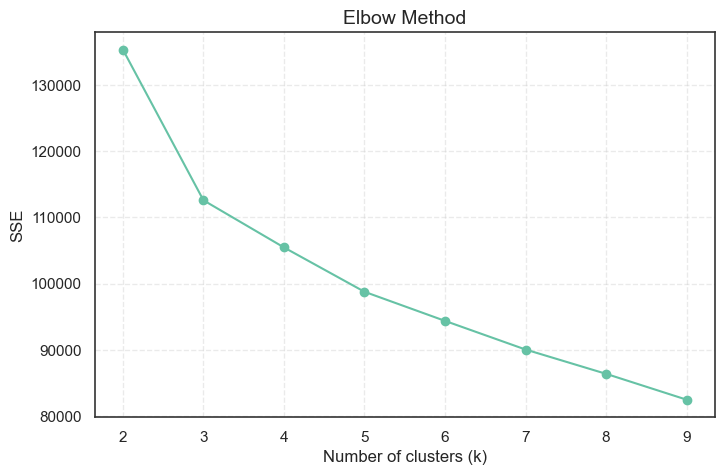

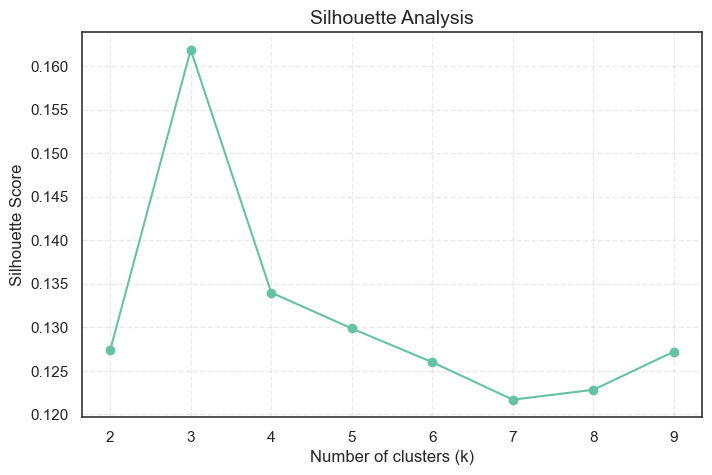

Best k based on silhouette score: 3
Silhouette score at best k: 0.162


In [7]:
best_k, results = find_optimal_k(X, k_min=2, k_max=10, show_plots=True)

In [8]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
df_clustering_data['cluster_id'] = kmeans.labels_

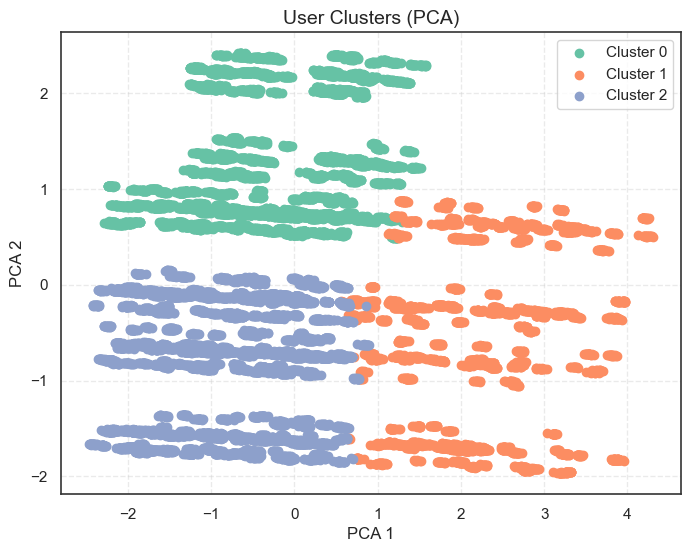

In [9]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for cluster in range(3):
    plt.scatter(
        X_pca[df_clustering_data['cluster_id'] == cluster, 0],
        X_pca[df_clustering_data['cluster_id'] == cluster, 1],
        label=f'Cluster {cluster}'
    )
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('User Clusters (PCA)')
plt.legend()
plt.show()

In [10]:
columns = [
    "Age",
    "Weight (kg)",
    "Height (m)",
    "BMI",
    "Experience_Level",
    "Workout_Frequency (days/week)",
    "Daily meals frequency",
    "Gender_Female",
    "Gender_Male",
    "diet_type_Balanced",
    "diet_type_Keto",
    "diet_type_Low-Carb",
    "diet_type_Paleo",
    "diet_type_Vegan",
    "diet_type_Vegetarian"
]

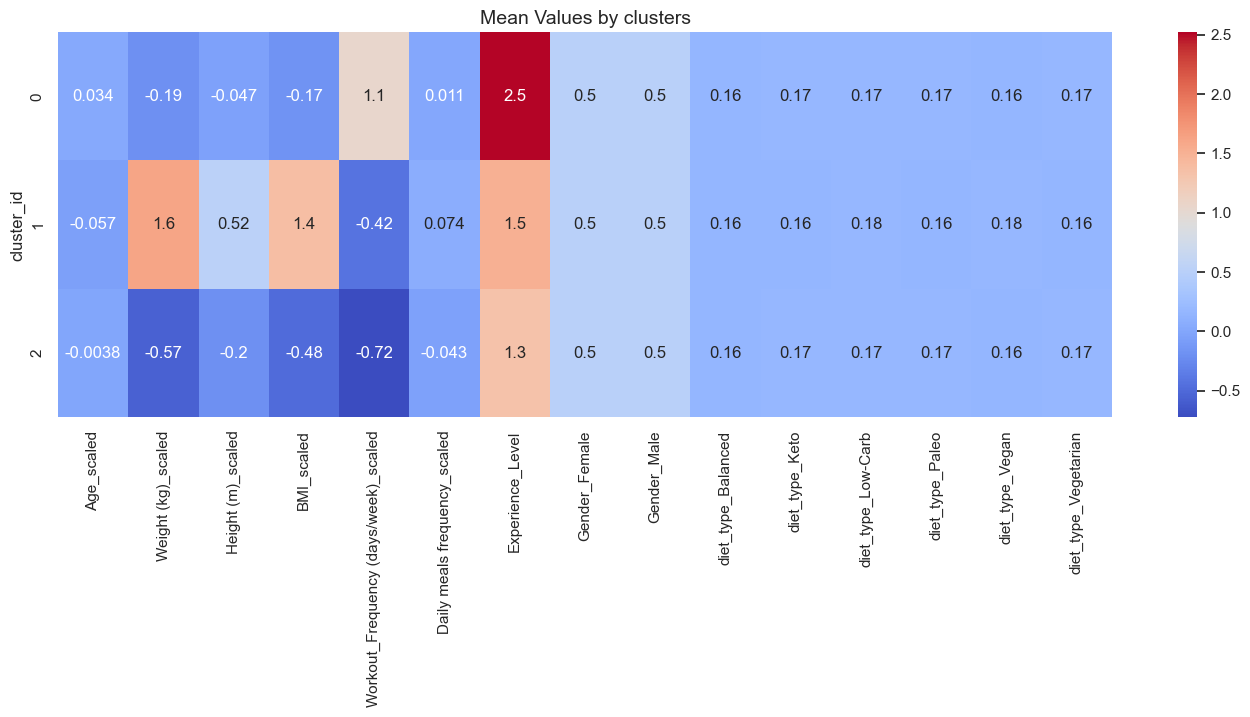

In [11]:
cluster_means = df_clustering_data.groupby('cluster_id')[scaled_numeric_cols + categorical_scaled_cols].mean()

plt.figure(figsize=(17,5))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm')
plt.title('Mean Values by clusters')
plt.show()


Let's remove categorical variables such as gender and diet type were excluded from the clustering process and make clustering  using only scaled numerical features. This approach improved cluster separation and resulted in a higher silhouette score.

### K-Means clustering without diet_type and Gender (Accepted Clustering Version)

In [12]:
features_no_diet = [c for c in final_features if not c.startswith('diet_type') and not c.startswith('Gender')]
X2 = df_clustering_data[features_no_diet].values

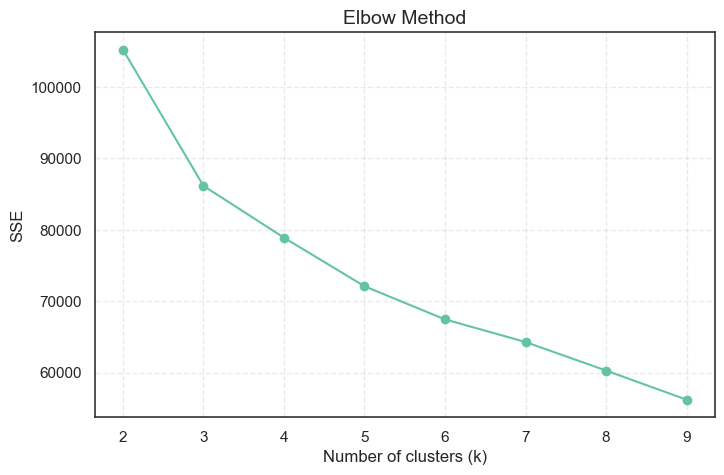

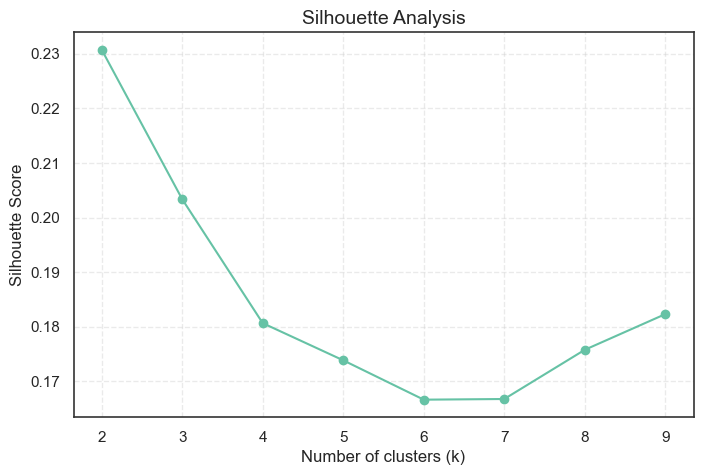

Best k based on silhouette score: 2
Silhouette score at best k: 0.231


In [13]:
best_k, results = find_optimal_k(X2, k_min=2, k_max=10, show_plots=True)

In [14]:
kmeans_X2 = KMeans(n_clusters=3, random_state=42)
kmeans_X2.fit(X2)
df_clustering_data['cluster_id'] = kmeans_X2.labels_

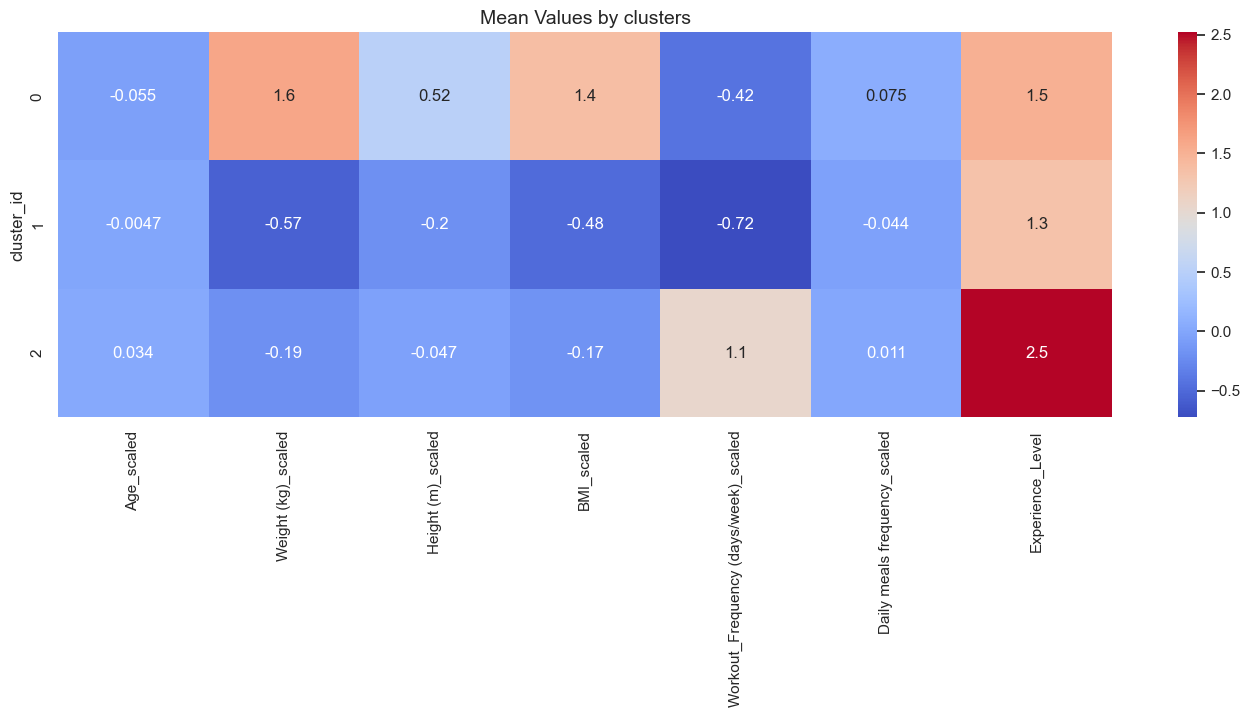

In [15]:
cluster_means = df_clustering_data.groupby('cluster_id')[features_no_diet].mean()

plt.figure(figsize=(17,5))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm')
plt.title('Mean Values by clusters')
plt.show()

### K-Means clustering results

The clustering results reveal three distinct user groups primarily differentiated by BMI and workout frequency rather than age. This suggests that lifestyle and physical activity play a stronger role in user segmentation than demographic factors. 

In [16]:
cluster_descriptions = {
    0: "Overweight & low activity",
    1: "Normal weight & low activity",
    2: "Active & fit"
}
df_clustering_data['cluster_description'] = df_clustering_data['cluster_id'].map(cluster_descriptions)
df_clustering_data.head()

,Age,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days/week),Daily meals frequency,Gender_Female,Gender_Male,diet_type_Balanced,diet_type_Keto,diet_type_Low-Carb,diet_type_Paleo,diet_type_Vegan,diet_type_Vegetarian,Age_scaled,Weight (kg)_scaled,Height (m)_scaled,BMI_scaled,Workout_Frequency (days/week)_scaled,Daily meals frequency_scaled,cluster_id,cluster_description
0,35,65.27,1.62,24.87,2,4,3,False,True,False,False,False,False,True,False,-0.321350,-0.403548,-0.811881,-0.001794,0.743868,0.211608,2,Active & fit
1,23,56.41,1.55,23.48,2,4,3,True,False,False,False,False,False,False,True,-1.312164,-0.823087,-1.362754,-0.210191,0.743868,0.211608,2,Active & fit
2,33,58.98,1.67,21.15,1,3,2,True,False,False,False,False,True,False,False,-0.486485,-0.701392,-0.418400,-0.559517,-0.351407,-1.360622,1,Normal weight & low activity
3,39,93.78,1.70,32.45,2,4,3,True,False,False,False,False,True,False,False,0.008922,0.946458,-0.182312,1.134640,0.743868,0.211608,0,Overweight & low activity
4,45,52.42,1.88,14.83,2,4,3,False,True,False,False,False,False,True,False,0.504329,-1.012022,1.234219,-1.507045,0.743868,0.211608,2,Active & fit


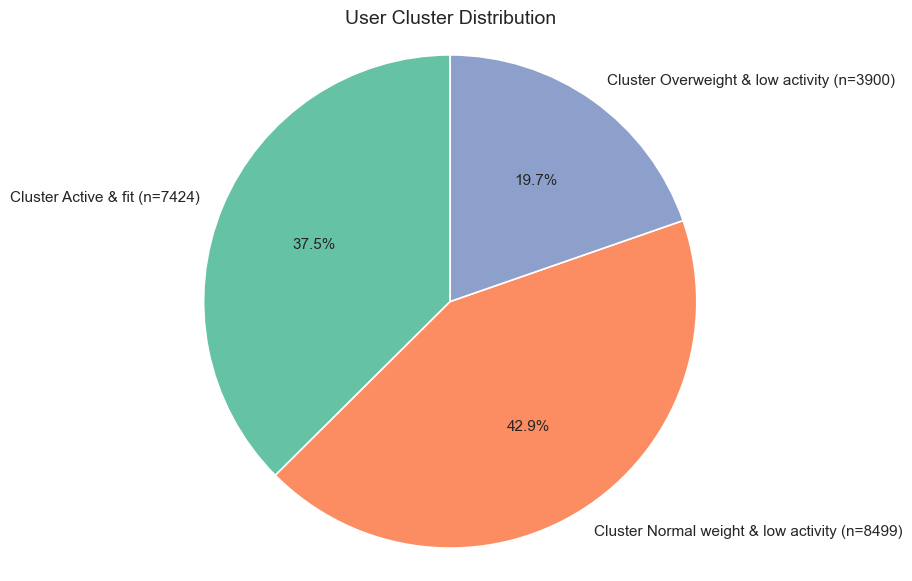

In [17]:
cluster_counts = df_clustering_data['cluster_description'].value_counts().sort_index()

labels = [f"Cluster {i} (n={cluster_counts[i]})" for i in cluster_counts.index]
colors = BASE_PALETTE[:len(cluster_counts)]

plt.figure(figsize=(7, 7))
plt.pie(
    cluster_counts.values,
    labels=labels,
    autopct=lambda p: f"{p:.1f}%",
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "white", "linewidth": 1.2},
    textprops={"fontsize": 11}
)
plt.title("User Cluster Distribution")
plt.axis("equal")  
plt.show()


### K-Means Clustering evaluation

Although the silhouette score is moderate, the clusters are stable and highly interpretable, which supports their practical relevance.

In [18]:
scores = []

for seed in range(10):
    kmeans = KMeans(n_clusters=3, random_state=seed)
    labels = kmeans.fit_predict(X2)
    score = silhouette_score(X2, labels)
    scores.append(score)

print("Silhouette stability over random initializations:")
for i, s in enumerate(scores):
    print(f"  Seed {i:2d}: {s:.7f}")

print("\nSummary:")
print(f"  Mean silhouette score: {np.mean(scores)}")
print(f"  Std deviation:         {np.std(scores)}")


Silhouette stability over random initializations:
  Seed  0: 0.2033800
  Seed  1: 0.2033800
  Seed  2: 0.2033692
  Seed  3: 0.2033601
  Seed  4: 0.2033725
  Seed  5: 0.2033861
  Seed  6: 0.2033800
  Seed  7: 0.2033732
  Seed  8: 0.2033671
  Seed  9: 0.2033750

Summary:
  Mean silhouette score: 0.20337433323747073
  Std deviation:         7.216768141512571e-06


In [19]:
cluster_means_unscaled = df_clustering_data.groupby('cluster_id')[numeric_cols].mean()
display(cluster_means_unscaled)

,Age,Weight (kg),Height (m),BMI,Workout_Frequency (days/week),Daily meals frequency
cluster_id,,,,,,
0,38.221282,107.753549,1.789074,34.040618,2.934103,2.912821
1,38.834922,61.790261,1.698168,21.655504,2.660784,2.837628
2,39.309537,69.691600,1.717162,23.764372,4.279634,2.872306


### Chosen Model: Although the silhouette score is maximized at k = 2 for X dataset, the elbow method consistently indicates k = 3, and k = 3 provides more interpretable and actionable number of user segments from business logic, so we decide to take the model with Silhouette = 0.231, but k = 3 . 

In [20]:
from joblib import dump

artifacts = {
    "kmeans": kmeans_X2,
    "numeric_cols": numeric_cols,
    "mean_dict": mean_dict,
    "std_dict": std_dict,
    "features_no_diet": features_no_diet,   
    "dropped_prefixes": ("diet_type", "Gender")
}

dump(artifacts, "models/kmeans_user_cluster.joblib")
print("Saved -> models/kmeans_user_cluster.joblib")

Saved -> models/kmeans_user_cluster.joblib


In [21]:
from functions import predict_cluster_id

# load dataset_with_user_features CSV
new_user_df = pd.read_csv("data/dataset_with_user_features.csv")

# predict cluster
result_df = predict_cluster_id(
    new_user_df,
    artifacts_path="models/kmeans_user_cluster.joblib"
)

In [22]:
result_df.head(3)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Daily meals frequency,Calories,sugar_g,serving_size_g,rating,Name of Exercise,Sets,Reps,Benefit,Burns Calories (per 30 min),Target Muscle Group,Equipment Needed,Difficulty Level,Body Part,Type of Muscle,Workout,sodium_g,cholesterol_g,Carbs,Proteins,Fats,meal_name,BMR,PAL,TDEE,cluster_id
0,35,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,1.50,4,2,24.87,3,1806.0,31.77,120.47,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,342.58,"Shoulders, Triceps",Cable Machine,3,Legs,Lats,Dumbbell flyes,1.72994,0.28505,267.68,106.05,71.63,Grilled Vegan Lunch,1495.20,1.900,2840.88000,2
1,23,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,1.90,4,2,23.48,3,1577.0,12.34,109.15,1.92,Bear Crawls,4,16,Strengthens lower abs,357.16,"Back, Core, Shoulders",Step or Box,2,Chest,Lats,Lateral raises,0.69308,0.30061,214.32,85.41,56.97,Fried Vegetarian Lunch,1256.85,1.900,2388.01500,2
2,33,Female,58.98,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,1.88,3,1,21.15,2,1608.0,42.81,399.43,4.70,Dips,5,22,Builds chest strength,359.63,"Quadriceps, Glutes",Step or Box,2,Arms,Grip Strength,Standing calf raises,2.14248,0.21542,246.04,98.11,65.48,Boiled Paleo Breakfast,1307.55,1.725,2255.52375,1


In [23]:
result_df.to_csv(
    "data/dataset_with_clusters.csv",
    index=False
)
print("Dataset with clusters is saved!")

Dataset with clusters is saved!
